## Setup

In [233]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import glob
import pandas as pd
import os.path as op
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import scipy as sp
from scipy import stats

import folium
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.cm as cm
from collections import namedtuple

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.precision', 5)
pd.set_option('chained_assignment', None)
sns.set_style("white")
sns.despine()
#sns.set_context("poster", font_scale=3, rc={"lines.linewidth": 1.5})
sns.set(style="ticks", font_scale=1, font='Arial', rc={"lines.linewidth": 2,'axes.labelcolor':[0,0,0], 'axes.edgecolor':[0,0,0],
'xtick.color':[0,0,0], 'ytick.color':[0,0,0],'text.color':[0,0,0],'axes.linewidth': 2, "font.size":13,"axes.titlesize":14,"axes.labelsize":12,
                                                                        "xtick.labelsize":12, "ytick.labelsize":12})
plt.figure(figsize=(10, 10))
mpl.rc("savefig", dpi=300)
sns.set(style="ticks",context='notebook')

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Load Data

In [5]:
path = '/Volumes/data/Avi/Analysis/Citibike/data'
csvs = glob.glob('%s/*tripdata.csv*'%path)
print('Analyzing %s months of data' %len(csvs))

Analyzing 12 months of data


In [6]:
trips_all = []
for csv in csvs:
    print('Reading' + csv)
    trips_month = pd.read_csv(csv)
    trips_all.append(trips_month)

trips_all = pd.concat(trips_all)

Reading/Volumes/data/Avi/Analysis/Citibike/data/201806-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/data/201810-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/data/201809-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/data/201904-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/data/201901-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/data/201812-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/data/201807-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/data/201811-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/data/201808-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/data/201905-citibike-tripdata.csv.zip
Reading/Volumes/data/Avi/Analysis/Citibike/data/201902-citibike-tripdata.csv
Reading/Volumes/data/Avi/Analysis/Citibike/data/201903-citibike-tripdata.csv.zip


### Describe data

In [7]:
print(trips_all.columns.values)

['tripduration' 'starttime' 'stoptime' 'start station id'
 'start station name' 'start station latitude' 'start station longitude'
 'end station id' 'end station name' 'end station latitude'
 'end station longitude' 'bikeid' 'usertype' 'birth year' 'gender']


In [8]:
# Drop columns we don't need
trips_all = trips_all.drop(columns = ['bikeid','stoptime'])

In [10]:
# Split starttime and end time into day month year hour variable

trips_all['starttime'] = pd.to_datetime(trips_all['starttime'], format='%Y-%m-%d %H:%M:%S')


trips_all['startyear']= pd.DatetimeIndex(trips_all['starttime']).year
trips_all['startmonth']= pd.DatetimeIndex(trips_all['starttime']).month.map("{:02}".format)
trips_all['startday']= pd.DatetimeIndex(trips_all['starttime']).day
trips_all['starthour']= pd.DatetimeIndex(trips_all['starttime']).hour
trips_all['startminute']= pd.DatetimeIndex(trips_all['starttime']).minute

trips_all['startyearmonth']= trips_all['startyear'].map(str) + "-" + trips_all['startmonth'].map(str)
trips_all['dayofweek'] = pd.DatetimeIndex(trips_all['starttime']).dayofweek
trips_all['weekend'] = np.where(trips_all['dayofweek'] < 5, 0, 1)

In [184]:
trips_all['startday']= pd.DatetimeIndex(trips_all['starttime']).day
trips_all['starthour']= pd.DatetimeIndex(trips_all['starttime']).hour
trips_all['startminute']= pd.DatetimeIndex(trips_all['starttime']).minute

In [201]:
trips_all.head()

,tripduration,starttime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,...,startyear,startmonth,startday,starthour,startyearmonth,dayofweek,weekend,age,ageband,startminute
0,569,2018-06-01 01:57:20.514,72.00,W 52 St & 11 Ave,40.77,-73.99,173.00,Broadway & W 49 St,40.76,-73.98,...,2018,06,1,1,2018-06,4,0,19,1,57
1,480,2018-06-01 02:02:42.398,72.00,W 52 St & 11 Ave,40.77,-73.99,477.00,W 41 St & 8 Ave,40.76,-73.99,...,2018,06,1,2,2018-06,4,0,30,2,2
2,692,2018-06-01 02:04:23.624,72.00,W 52 St & 11 Ave,40.77,-73.99,457.00,Broadway & W 58 St,40.77,-73.98,...,2018,06,1,2,2018-06,4,0,32,2,4
3,664,2018-06-01 03:00:55.461,72.00,W 52 St & 11 Ave,40.77,-73.99,379.00,W 31 St & 7 Ave,40.75,-73.99,...,2018,06,1,3,2018-06,4,0,45,3,0
4,818,2018-06-01 06:04:54.427,72.00,W 52 St & 11 Ave,40.77,-73.99,459.00,W 20 St & 11 Ave,40.75,-74.01,...,2018,06,1,6,2018-06,4,0,34,2,4


In [13]:
trips_all.shape

(18806954, 20)

In [185]:
pd.set_option('display.float_format', '{:.2f}'.format)
trips_all.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,gender,startyear,startday,starthour,dayofweek,weekend,age,startminute
count,18783940.00,18783940.00,18783940.00,18783940.00,18783940.00,18783940.00,18783940.00,18783940.00,18783940.00,18783940.00,18783940.00,18783940.00,18783940.00,18783940.00,18783940.00
mean,850.69,1631.51,40.74,-73.98,1622.97,40.74,-73.98,1.16,2018.37,15.65,13.88,2.87,0.24,38.88,29.52
std,1392.56,1455.47,0.03,0.02,1454.79,0.03,0.02,0.54,0.48,8.78,4.84,1.93,0.43,11.80,17.28
min,61.00,72.00,40.65,-74.03,72.00,40.65,-74.08,0.00,2018.00,1.00,0.00,0.00,0.00,16.00,0.00
25%,355.00,382.00,40.72,-74.00,382.00,40.72,-74.00,1.00,2018.00,8.00,10.00,1.00,0.00,29.00,14.00
50%,602.00,509.00,40.74,-73.99,508.00,40.74,-73.99,1.00,2018.00,16.00,14.00,3.00,0.00,36.00,30.00
75%,1060.00,3263.00,40.76,-73.97,3260.00,40.76,-73.97,1.00,2019.00,23.00,18.00,4.00,0.00,49.00,45.00
max,86385.00,3790.00,45.51,-73.57,3790.00,45.51,-73.57,2.00,2019.00,31.00,23.00,6.00,1.00,84.00,59.00


Check for missing data

In [16]:
trips_all.isnull().sum()

tripduration                  0
starttime                     0
start station id           2534
start station name         2534
start station latitude        0
start station longitude       0
end station id             2534
end station name           2534
end station latitude          0
end station longitude         0
usertype                      0
birth year                    0
gender                        0
startyear                     0
startmonth                    0
startday                      0
starthour                     0
startyearmonth                0
dayofweek                     0
weekend                       0
dtype: int64

In [27]:
# Exclude trips that lasted over 24 hours
trips_all = trips_all[trips_all['tripduration'] < 86400]

# Exclude trips will null station ids
trips_all = trips_all[trips_all['start station id'].notnull()]



In [28]:
# Convert birth year to approx age
trips_all['age'] = trips_all['startyear'] - trips_all['birth year']
trips_all = trips_all.drop(columns = ['birth year'])
trips_all = trips_all[trips_all['age']<85]
trips_all['ageband'] = pd.cut(trips_all['age'], 5, labels=[1, 2,3,4,5])

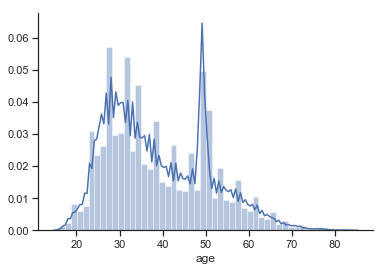

In [29]:
sns.distplot(trips_all['age'])
sns.despine()

In [206]:
month_trips_count = trips_all.groupby('startyearmonth')['tripduration'].count()

In [207]:
month_trips_count

startyearmonth
2018-06    1950554
2018-07    1911585
2018-08    1973760
2018-09    1875270
2018-10    1876815
2018-11    1259018
2018-12    1015116
2019-01     966004
2019-02     942808
2019-03    1326383
2019-04    1763996
2019-05    1922631
Name: tripduration, dtype: int64

In [217]:
minute_trips_count = trips_all.groupby(['startminute','weekend']).size().reset_index(name='counts')


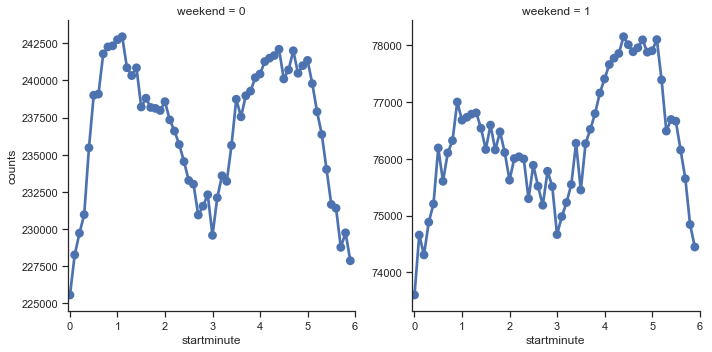

In [246]:
a = sns.catplot('startminute',y = 'counts', col='weekend', kind='point',sharey= False, data =minute_trips_count)
a= a.set(xticks=[0,10,20,30,40,50,60],xticklables)
sns.despine()

In [71]:
month_trips_count = trips_all[['startyearmonth','tripduration']].groupby(['startyearmonth'], as_index=False).count().sort_values(by='startyearmonth', ascending=True)
month_trips_duration = trips_all[['startyearmonth','tripduration']].groupby(['startyearmonth'], as_index=False).mean().sort_values(by='startyearmonth', ascending=True)

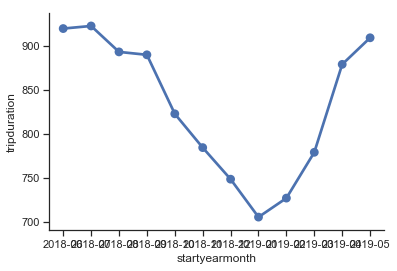

In [74]:
sns.pointplot('startyearmonth',y = 'tripduration',data =month_trips_duration)
sns.despine()

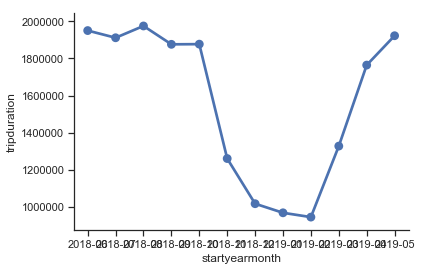

In [75]:
sns.pointplot('startyearmonth',y = 'tripduration',data =month_trips_count)
sns.despine()

In [20]:
## Create table of station lat and long for start and end stations
start_stations = trips_all.loc[:,['start station name', 'start station id', 'start station latitude', 'start station longitude']]
start_stations.index = start_stations['start station name']
start_stations = start_stations.drop_duplicates()
start_stations.head()

,start station name,start station id,start station latitude,start station longitude
start station name,,,,
W 52 St & 11 Ave,W 52 St & 11 Ave,72.00,40.77,-73.99
Franklin St & W Broadway,Franklin St & W Broadway,79.00,40.72,-74.01
St James Pl & Pearl St,St James Pl & Pearl St,82.00,40.71,-74.00
Atlantic Ave & Fort Greene Pl,Atlantic Ave & Fort Greene Pl,83.00,40.68,-73.98
Park Ave & St Edwards St,Park Ave & St Edwards St,119.00,40.70,-73.98


In [21]:
end_stations = trips_all.loc[:,['end station name', 'end station id', 'end station latitude', 'end station longitude']]
end_stations.index = end_stations['end station name']
end_stations = end_stations.drop_duplicates()
end_stations.head()

,end station name,end station id,end station latitude,end station longitude
end station name,,,,
Broadway & W 49 St,Broadway & W 49 St,173.00,40.76,-73.98
W 41 St & 8 Ave,W 41 St & 8 Ave,477.00,40.76,-73.99
Broadway & W 58 St,Broadway & W 58 St,457.00,40.77,-73.98
W 31 St & 7 Ave,W 31 St & 7 Ave,379.00,40.75,-73.99
W 20 St & 11 Ave,W 20 St & 11 Ave,459.00,40.75,-74.01


In [30]:
def most_popular_routes(df,num_routes,start_stations,end_stations):
    
    # count number of trips for every station combination
    df = pd.crosstab(df['start station name'],df['end station name']).unstack().reset_index().rename(columns= {0:'count'})
    
    # do not include trips to and from same station
    df = df[df['end station name'] != df['start station name']]
    
    # get top n number of routes 
    df_top = df.nlargest(num_routes, 'count')
    
    df_top = df_top.merge(start_stations)
    df_top = df_top.merge(end_stations)
    
    return df_top
    

In [120]:
def get_arrows(locations, color='blue', size=3, n_arrows=3):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill_color=color, number_of_sides=3, 
                      radius=size, rotation=rotation))
    return arrows

In [121]:
def get_bearing(p1, p2):
    
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

In [177]:
def create_map(df,start_stations,end_stations,num_routes=10):
    
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    folium map 
    
    '''
    # get top n stations for df provided
    df_n = most_popular_routes(df,num_routes,start_stations,end_stations)
    
    min_count = df_n['count'].min()
    #norm = Normalize(df_n['count'].min(), df_n['count'].max())
    
    # draw map
    tileset = r'http://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png'
    station_map = folium.Map(location = [40.74, -73.99], width = 400, height = 600,
                               tiles = tileset,
                               attr = '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
                               zoom_start = 12)

    for index, row in df_n.iterrows():
    
        folium.CircleMarker(location = [row['start station latitude'],
                                              row['start station longitude']],
                                  popup = row['start station name'],
                        radius= 2.5, color = ['#888888'], fill_color = ['#888888'],line_color = ['#888888'],
                            opacity=[1]).add_to(station_map)
        
        folium.CircleMarker(location = [row['end station latitude'],
                                              row['end station longitude']],
                                  popup = row['end station name'],
                              radius = 2.5, color = ['#888888'],  fill_color = ['#888888'],line_color = ['#888888'],
                            opacity=[1]).add_to(station_map)
    
        p1 = [row['start station latitude'],row['start station longitude']]
        p2 = [row['end station latitude'],row['end station longitude']]
        
        #color = rgb2hex(cm.YlOrRd(norm(row['count'])))
    
        folium.PolyLine(locations = [p1,p2], weight = row['count']/(min_count/4),
                        popup =  row['count'],
                        color = ['#5DADE2'],opacity=[.6]).add_to(station_map)
    
        arrows = get_arrows(locations=[p1, p2], color = ['#1A5276'],  n_arrows=1)
    
        for arrow in arrows:
            arrow.add_to(station_map)
            
    
    return station_map    

    

In [196]:
trips_weekday.loc[ (trips_weekday['starthour'] == 1) & (trips_weekday['startminute'] <15), ['start station name', 'end station name']]

,start station name,end station name
389,W 52 St & 11 Ave,MacDougal St & Washington Sq
694,W 52 St & 11 Ave,Broadway & W 49 St
1539,W 52 St & 11 Ave,W 42 St & 8 Ave
1540,W 52 St & 11 Ave,W 31 St & 7 Ave
2172,W 52 St & 11 Ave,W 42 St & 8 Ave
2971,W 52 St & 11 Ave,W 42 St & 8 Ave
4159,W 52 St & 11 Ave,Christopher St & Greenwich St
4259,W 52 St & 11 Ave,Broadway & W 49 St
4260,W 52 St & 11 Ave,W 42 St & 8 Ave
4560,Franklin St & W Broadway,Graham Ave & Conselyea St


In [200]:
## Create maps of top 10 routes for every hour during week
df = trips_weekday
num_routes = 20
minblock = 60/4
print('Creating maps for hourly subset:')
for hour in range(24):
    for minuteblock in range(4):
        print('... ' + str(hour) + ' hrs')
        
        minute_min = minuteblock*minblock
        minute_max = minute_min + minblock-1
    
        trips_hour = df.loc[ (df['starthour'] == 1) & (minute_min< df['startminute']) & (df['startminute'] <minute_max), ['start station name', 'end station name']]
    
        hour_map = create_map(trips_hour,start_stations,end_stations,num_routes)
    
        hour_map.save('maps/' + "{0:0=2d}".format(hour) + '_' + "{0:0=2d}".format(minuteblock) + '_route_map.html')

Creating maps for hourly subset:
... 0 hrs
... 0 hrs
... 0 hrs
... 0 hrs
... 1 hrs
... 1 hrs
... 1 hrs
... 1 hrs
... 2 hrs
... 2 hrs
... 2 hrs
... 2 hrs
... 3 hrs
... 3 hrs
... 3 hrs
... 3 hrs
... 4 hrs
... 4 hrs
... 4 hrs
... 4 hrs
... 5 hrs
... 5 hrs
... 5 hrs
... 5 hrs
... 6 hrs
... 6 hrs
... 6 hrs
... 6 hrs
... 7 hrs
... 7 hrs
... 7 hrs
... 7 hrs
... 8 hrs
... 8 hrs
... 8 hrs
... 8 hrs
... 9 hrs
... 9 hrs
... 9 hrs
... 9 hrs
... 10 hrs
... 10 hrs
... 10 hrs
... 10 hrs
... 11 hrs
... 11 hrs
... 11 hrs
... 11 hrs
... 12 hrs
... 12 hrs
... 12 hrs
... 12 hrs
... 13 hrs
... 13 hrs
... 13 hrs
... 13 hrs
... 14 hrs
... 14 hrs
... 14 hrs
... 14 hrs
... 15 hrs
... 15 hrs
... 15 hrs
... 15 hrs
... 16 hrs
... 16 hrs
... 16 hrs
... 16 hrs
... 17 hrs
... 17 hrs
... 17 hrs
... 17 hrs
... 18 hrs
... 18 hrs
... 18 hrs
... 18 hrs
... 19 hrs
... 19 hrs
... 19 hrs
... 19 hrs
... 20 hrs
... 20 hrs
... 20 hrs
... 20 hrs
... 21 hrs
... 21 hrs
... 21 hrs
... 21 hrs
... 22 hrs
... 22 hrs
... 22 hrs
... 22

In [147]:
aa = create_map(trips_all,start_stations,end_stations,6)

In [138]:
def create_map2(df,start_stations,end_stations,num_routes= 10,m=None):
    
    # get top n stations for df provided
    df_n = most_popular_routes(df,num_routes,start_stations,end_stations)
    
    min_count = df_n['count'].min()
    norm = Normalize(df_n['count'].min(), df_n['count'].max())
    
    # draw map
    tileset = r'http://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png'
    if m is None:
        station_map = folium.Map(location = [40.74, -73.99], width = 400, height = 600,
                               tiles = tileset,
                               attr = '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
                               zoom_start = 12)
    else:
        station_map = m

    for index, row in df_n.iterrows():
    
        folium.CircleMarker(location = [row['start station latitude'],
                                              row['start station longitude']],
                                  popup = row['start station name'],
                        radius= 2, fill_color = ['#006400'],opacity=[.6]).add_to(station_map)
        
        folium.CircleMarker(location = [row['end station latitude'],
                                              row['end station longitude']],
                                  popup = row['end station name'],
                              radius = 2,  fill_color = ['#008000'],opacity=[.6]).add_to(station_map)
    
        p1 = [row['start station latitude'],row['start station longitude']]
        p2 = [row['end station latitude'],row['end station longitude']]
        
        color = rgb2hex(cm.YlOrRd(norm(row['count'])))
    
        folium.PolyLine(locations = [p1,p2], weight = row['count']/(min_count/4),
                        popup =  row['count'],
                        color = color,opacity=[.4]).add_to(station_map)
    
        arrows = get_arrows(locations=[p1, p2], n_arrows=1)
    
        for arrow in arrows:
            arrow.add_to(station_map)
            
    
    return station_map    


In [139]:
all_m = create_map2(trips_all,start_stations,end_stations,10)

In [178]:
create_map(trips_male,start_stations,end_stations,10)

In [205]:
create_map(trips_female,start_stations,end_stations,10)

In [187]:
trips_male = trips_all[trips_all['gender'] == 1]
trips_female = trips_all[trips_all['gender'] == 2]

trips_weekday = trips_all[trips_all['weekend'] == 0]

## Check for gender differences

In [174]:
# Select only trips where the gender is known
trips_gender = trips_all.loc[trips_all['gender'].isin([1,2])]

In [162]:
pd.crosstab(trips_gender ['gender'],trips_gender['weekend'], normalize= 'columns')
    

weekend,0,1
gender,,
1,0.75567,0.71224
2,0.24433,0.28776


In [175]:
pd.crosstab(trips_gender ['gender'],trips_gender['ageband'], normalize= 'columns')

ageband,1,2,3,4,5
gender,,,,,
1,0.71451,0.75399,0.76204,0.76571,0.77856
2,0.28549,0.24601,0.23796,0.23429,0.22144


In [180]:
pd.crosstab(trips_gender ['gender'],[trips_gender['ageband'],trips_gender['weekend']], normalize= 'columns')

ageband        1                 2                 3                 4  \
weekend        0        1        0        1        0        1        0   
gender                                                                   
1        0.72209  0.69355  0.76407  0.71964  0.77288  0.71786  0.77387   
2        0.27791  0.30645  0.23593  0.28036  0.22712  0.28214  0.22613   

ageband                 5           
weekend        1        0        1  
gender                              
1        0.73431  0.78222  0.76583  
2        0.26569  0.21778  0.23417